# Feature Transformations - Assignment 11

## Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
perov = pd.read_csv('data/perovskite_data.csv')

## 1. One-hot Encoding

**Creat a matrix of one-hot encoded features.**  

Use the `X` column of the perovskite dataset (corresponding to the identity of the `X` ion in the ABX$_3$ coumpound).

In [3]:
X_onehot = pd.get_dummies(perov['X'])

In [4]:
X_onehot.head(5)

,Br,Cl,F,I,O
0,0,0,0,0,1
1,0,0,0,0,1
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,0,0,1


**Print the dimensions of the matrix.**

In [5]:
print(X_onehot.shape)

(576, 5)


**Print the sum across all rows for each feature.**

In [6]:
print(X_onehot.sum(axis = 0))

Br     27
Cl     71
F      66
I      43
O     369
dtype: int64


**One-hot encoding for a categorical variable**

Consider a dataset consisting of a single categorical variable with a total of $N$ datapoints and corresponding outputs, $y$. Assume that each datapoint has a unique category label such that there are $N$ distinct categories. You apply one-hot encoding to create a new feature matrix, $\bar{\bar{X}}$ and decide to fit a linear regression model:

$\vec{y} = \bar{\bar{X}}\vec{w}$

What will the optimal values of $\vec{w}$ be and the $R^2$ be? You can use code, math, or a conceptual explanation to answer this question.

> N datapoints with N distinct categories will result in an N x N feature matrix $\bar{\bar{X}}$ where all diagonal elements are 1 and others are 0. This is simply an identitiy matrix in which case $\vec{w}$ will be exactly identical to $\vec{y}$. Therefore, the optimal $\vec{w}$ will be $\vec{y}$ and the corresponding $r^2$ will be 1.0.

**Is this a reliable model? Briefly explain.**

> This is not a reliable model. It just memorizes the $\vec{y}$ such that it will break when a new kind of data is introduced.

## 2. PCA vs. LDA

**Load the MNIST dataset.**

In [7]:
from sklearn.datasets import load_digits

digits = load_digits()

X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

**Use `PCA` on the MNIST dataset.**  

Set `n_components` to 9.

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 9)
X_pca = pca.fit_transform(X_mnist)

**Apply k-means clustering to the PCA transformed data.**  

Set `n_clusters` to 10.

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10)
y_pca = kmeans.fit_predict(X_pca)

**Assign a label to each cluster by using the most common label from the cluster.**  

This step converts the clustering to a classification prediction. If the label 9 is most common in the cluster 1, all points belonging to that cluster should be labeled as 9. However, be aware that these labels may change if you re-run the clustering, so you probably want to assign them programatically rather than manually.

*Hint: `np.bincount()` function may be helpful.*

In [10]:
y_predict_pca = np.zeros(y_mnist.shape)

for i in range(10):
    collect_label = y_mnist[y_pca == i]
    count_label = np.bincount(collect_label)
    common_label = np.argmax(count_label)
    
    y_predict_pca[y_pca == i] = common_label

**Create a confusion matrix based on the clustering result.**

Plot the confusion matrix.

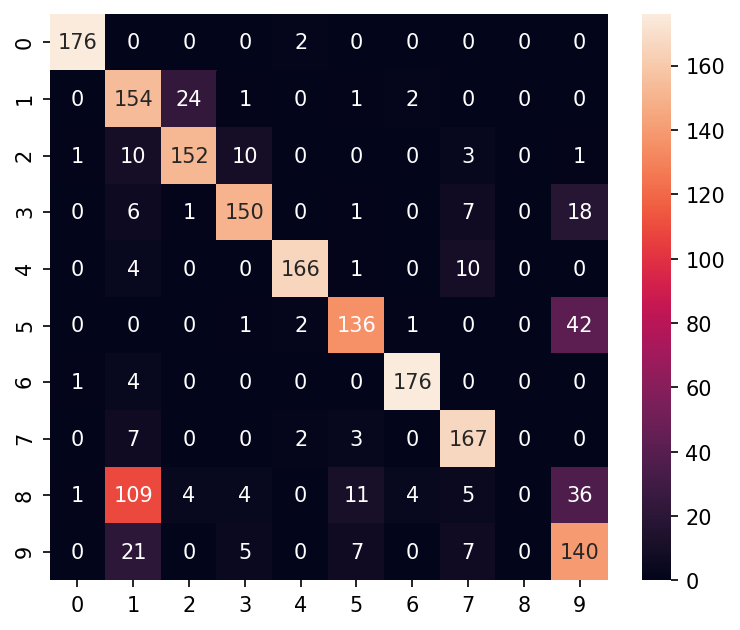

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_mnist, y_predict_pca)

fig, ax = plt.subplots(figsize = (6, 5), dpi = 150)
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax);

**Follow the same steps using `LDA` instead of `PCA`.**
- Use `LDA` on the MNIST dataset.
- Apply k-means clustering.
- Assign labels.
- Plot the resulting matrix.

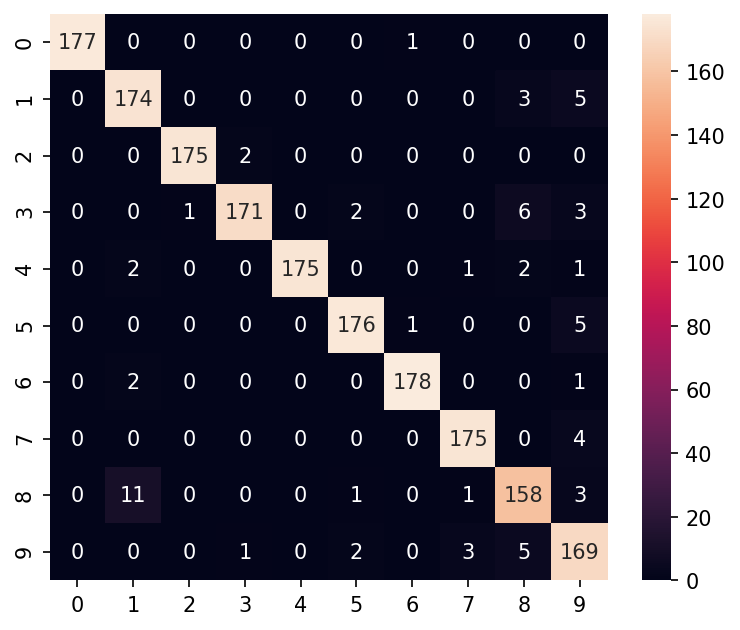

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_mnist, y_mnist)
X_lda = lda.transform(X_mnist)

kmeans = KMeans(n_clusters = 10)
y_lda = kmeans.fit_predict(X_lda)

y_predict_lda = np.zeros(y_mnist.shape)

for i in range(10):
    collect_label = y_mnist[y_lda == i]
    count_label = np.bincount(collect_label)
    common_label = np.argmax(count_label)
    
    y_predict_lda[y_lda == i] = common_label

fig, ax = plt.subplots(figsize = (6, 5), dpi = 150)
cm = confusion_matrix(y_mnist, y_predict_lda)
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax);

**Briefly discuss the results.**

> Clustering performs much better for the LDA-projectd data compared to the PCA-projected data. While the PCA-projected data struggles identifying 1 and 9, there are much less mispredictions for the LDA-projected data.

## 3. Symbolic Classification

**Drop `ABX3`, `t` and `tau` features of the perovskite dataset.**

In [13]:
dropped_perov = perov.drop(['ABX3', 't', 'tau', 'exp_label'], axis = 1)
y = perov['exp_label']

**Apply one-hot encoding to `dropped_perov`.**

In [14]:
one_hot_perov = pd.get_dummies(dropped_perov)

**Do a train/test split with `test_size`=0.3.**

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(one_hot_perov, y, test_size = 0.3)

**Train a `autofeat` classifier.**  

Use `transforms` below for the non-linear transformations.

In [16]:
from autofeat import AutoFeatClassifier

In [17]:
transforms = ['1/', 'exp', '^2', '^3']

autoClass = AutoFeatClassifier(verbose = 1, feateng_steps = 2, featsel_runs = 1, transformations = transforms)
autoClass.fit(X_train, y_train)

[AutoFeat] Warning: This just calls fit_transform() but does not return the transformed dataframe.
[AutoFeat] It is much more efficient to call fit_transform() instead of fit() and transform()!
[AutoFeat] The 2 step feature engineering process could generate up to 129286 features.
[AutoFeat] With 403 data points this new feature matrix would use about 0.21 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 20 transformed features from 127 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 2720 feature combinations from 10731 original feature tuples - done.
[feateng] Generated altogether 10735 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level


/Users/SihoonChoi/opt/anaconda3/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.core.add with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.core.add instead. See
https://github.com/sympy/sympy/issues/18245 for more info.

  deprecated_since_version="1.6").warn()


[feateng] Generated a total of 1189 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/1
[featsel] 2 features after 1 feature selection runs
[featsel] 2 features after correlation filtering
[featsel] 2 features after noise filtering
[AutoFeat] Computing 2 new features.
[AutoFeat]     2/    2 new features ...done.
[AutoFeat] Final dataframe with 129 feature columns (2 new).
[AutoFeat] Training final classification model.
[AutoFeat] Trained model: largest coefficients:
[0.23273175]
0.139453 * 1/(nB*rBAng)
0.124414 * rXAng/rAAng
[AutoFeat] Final score: 0.7270


AutoFeatClassifier(featsel_runs=1, transformations=['1/', 'exp', '^2', '^3'],
                   verbose=1)

**Print the 5 most important features.**

In [18]:
# Resulting new features and good_cols_ heavily depend on randomness of train_test_split
# Please don't deduct points just because the features are different from yours or mine

print('5 most important features: \n')
for feat in autoClass.good_cols_[:5]:
    print(feat)

5 most important features: 

rXAng/rAAng
1/(nB*rBAng)


**Print the accuracy on the test set.**

In [19]:
autoClass.score(X_test, y_test)

[AutoFeat] Computing 2 new features.
[AutoFeat]     2/    2 new features ...done.


0.7283236994219653